# Baseline for Hot Topics in Computer Vision - Seminar 2
## Addressing Label Scarcity in the Semantic Analysis of Earth Observation Imagery  

This is the modified baseline classifier. It takes in any dataset and does the same as the baseline classifier.

## Imports

In [1]:

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import datetime
import csv

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
#google colab
from google.colab import drive
drive.mount('/content/drive')


## Constants

In [2]:
# Mappings for utility
MAP_PERCENT_TO_AMOUNT = {
    "10" : 280,
    "25" : 700,
    "50" : 1400,
    "100": 2799
}

DAMAGE_LEVEL_TO_SCORE = {
    "destroyed" : 4,
    "major-damage" : 3,
    "minor-damage" : 2,
    "no-damage" : 1,
    "no-building" : 0
}

SCORE_TO_DAMAGE_LEVEL = {
    0 : "no-building",
    1 : "no-damage",
    2 : "minor-damage",
    3 : "major-damage",
    4 : "destroyed",
}

NUM_CLASSES = 5  # Number of output classes

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Configs

Define the Network as wanted.

In [3]:
PRETRAINED = False
BATCH_SIZE = 128
NUM_EPOCHS=5
LEARNING_RATE=0.001
MOMENTUM=0.9
ARCHITECTURE = "rn18"
MODEL_OPTIMIZER = "SGD"

## File Paths

- AUGMENTED_DATASET_DIR: Path to the directory of the dataset
- AUGMENTD_DATASET_NAME: Name of the dataset in AUGMENTED_DATASET_DIR
- DATASET_DIR: Path to the directory of the ordered original images (where the test set is)
- XVIEW2_TXT_FILE: Points to xview2.txt file
- MODEL_OUTPUT_DIR: Directory trained models should be saved to.

In [21]:
AUGMENTED_DATASET_NAME = "DATASET_NAME"
AUGMENTED_DATASET_DIR = "../augmented_datasets/" + AUGMENTED_DATASET_NAME + "/"

DATASET_DIR = "../dataset/"
XVIEW2_TXT_FILE = "../dataset/xview2.txt"
MODEL_OUTPUT_DIR = "../models/"

## Baseline Classifier

In [13]:
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifier, self).__init__()

        self.resnet = models.resnet18(pretrained=PRETRAINED)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x

## Data Utilities

In [325]:
def calc_mean_and_std_of_dataset(loader):
    mean = 0.0
    std = 0.0
    total_samples = 0

    for images, _ in loader:
        batch_size = images.size(0)
        images = images.view(batch_size, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_samples += batch_size

    mean /= total_samples
    std /= total_samples

    return mean, std

## Normalize Dataset

Calculate mean and standard deviation for RGB images.

Set SAVE_MEAN_AND_STD True to recalculate the dataset's mean and standard deviation

Set LOAD_MEAN_AND_STD True to load the already calculated mean and standard deviation

In [326]:
#TRAINING_SET_ENTRIES = open(XVIEW2_TXT_FILE,'r').read().splitlines()[:TRAIN_SET_SIZE]

SAVE_MEAN_AND_STD = False
if SAVE_MEAN_AND_STD:
    pre_norm_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    dataset = torchvision.datasets.ImageFolder(os.path.join(AUGMENTED_DATASET_DIR), transform=pre_norm_transform)

    #subset = [dataset[dataset.imgs.index((file_path, class_label))] for file_path, class_label in dataset.imgs if os.path.basename(file_path) in TRAINING_SET_ENTRIES]
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

    mean, std = calc_mean_and_std_of_dataset(loader=dataloader)
    mean = mean.tolist()
    std = std.tolist()

    if not os.path.exists(DATASET_METRICS_DIR):
            os.makedirs(DATASET_METRICS_DIR)
    with open(os.path.join(DATASET_METRICS_DIR, AUGMENTED_DATASET_NAME +"_augmented.json"), 'w') as json_file:
        json.dump({'mean':mean,'std':std}, json_file)

In [327]:
LOAD_MEAN_AND_STD = False
if LOAD_MEAN_AND_STD:
    with open(os.path.join(DATASET_METRICS_DIR, AUGMENTED_DATASET_NAME +"_augmented.json"), 'r') as data_metrics_json:
        data = json.load(data_metrics_json)

    mean = data['mean']
    std = data['std']


print(mean)
print(std)

[0.485, 0.456, 0.406]
[0.229, 0.224, 0.225]


## Load Dataloader

In [16]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

dataset = torchvision.datasets.ImageFolder(
    os.path.join(AUGMENTED_DATASET_DIR), transform=transform
)
#subset = [dataset[dataset.imgs.index((file_path, class_label))] for file_path, class_label in dataset.imgs if os.path.basename(file_path) in TRAINING_SET_ENTRIES]
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True
)

# Train model

In [17]:
TRAIN_MODEL = True
if TRAIN_MODEL:
    model = ResNetClassifier(NUM_CLASSES)
    model.to(DEVICE)

    optimizer = torch.optim.SGD(model.parameters(), LEARNING_RATE, MOMENTUM)
    criterion = nn.CrossEntropyLoss()

    # Train the model
    model.train()
    epoch_loss_list = []
    epoch_accuracy_list = []
    for epoch in range(NUM_EPOCHS):
        step_loss = []
        total = 0.0
        correct = 0.0
        for images, labels in dataloader:
            images, labels =  images.to(DEVICE),labels.to(DEVICE)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backward pass
            loss.backward()
            optimizer.step()

            step_loss.append(loss.item())
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = np.array(step_loss).mean()
        epoch_loss_list.append(epoch_loss)
        epoch_accuracy = 100.*correct/total
        epoch_accuracy_list.append(epoch_accuracy)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {epoch_loss:.3f}, Accuracy: {epoch_accuracy:.3f}")


/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/5, Loss: 1.555, Accuracy: 30.100
Epoch 2/5, Loss: 1.435, Accuracy: 42.100
Epoch 3/5, Loss: 1.376, Accuracy: 42.400
Epoch 4/5, Loss: 1.324, Accuracy: 47.900
Epoch 5/5, Loss: 1.262, Accuracy: 49.200


## Save Model

In [18]:

SAVE_MODEL = True
if SAVE_MODEL:
    out_dir = os.path.join(MODEL_OUTPUT_DIR,AUGMENTED_DATASET_NAME)
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    TIME_NOW_STR = datetime.datetime.now().strftime("%m-%d-%Y_%H-%M-%S")
    SAVE_MODEL_FILE = os.path.join(out_dir,TIME_NOW_STR)
    torch.save(model.state_dict(), SAVE_MODEL_FILE + '.pth')


## Plot Training Loss and Accuracy

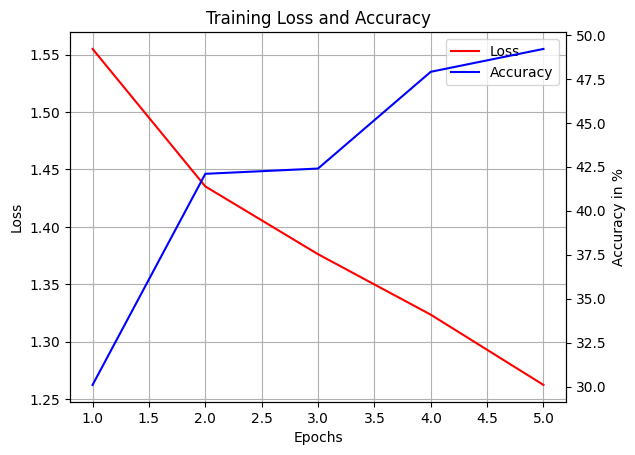

<Figure size 640x480 with 0 Axes>

In [19]:
if TRAIN_MODEL:
    # Plot Loss
    fig, ax1 = plt.subplots()
    ax1.plot(range(1,NUM_EPOCHS+1), epoch_loss_list, 'r-', label='Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss and Accuracy')
    ax1.grid(True)

    # Plot Accuracy
    ax2 = ax1.twinx()
    ax2.plot(range(1,NUM_EPOCHS+1), epoch_accuracy_list, 'b-', label='Accuracy')
    ax2.set_ylabel('Accuracy in %')

    # Add Legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines = lines1 + lines2
    labels = labels1 + labels2
    ax1.legend(lines, labels)

    plt.show()

    plt.savefig(os.path.join(out_dir, 'train_loss_accuracy.svg'), format='svg')

## Test Model

In [22]:
test_dataset = torchvision.datasets.ImageFolder(os.path.join(DATASET_DIR, "test"), transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=2, pin_memory=True)

In [23]:
LOAD_MODEL = False
LOAD_MODEL_FILE = MODEL_OUTPUT_DIR + "no_resize_25/"+ "07-01-2023_16-52-24.pth"
if LOAD_MODEL:
    model = ResNetClassifier(NUM_CLASSES)
    model.load_state_dict(torch.load(LOAD_MODEL_FILE))

In [24]:
model.eval()
model.to(DEVICE)

y_pred, y_truth = [], []

with torch.no_grad():
    for idx,(images, labels) in enumerate(test_dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Save Predictions and Ground Truth
        y_truth.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
# Calculate Accuracy
accuracy = correct / total
y_truth = torch.tensor(y_truth)
y_pred = torch.tensor(y_pred)

## Plot Confusion Matrix
Calculate Overall and Average Accuracy

Overall Accuracy: 0.269
Average Accuracy: 0.229


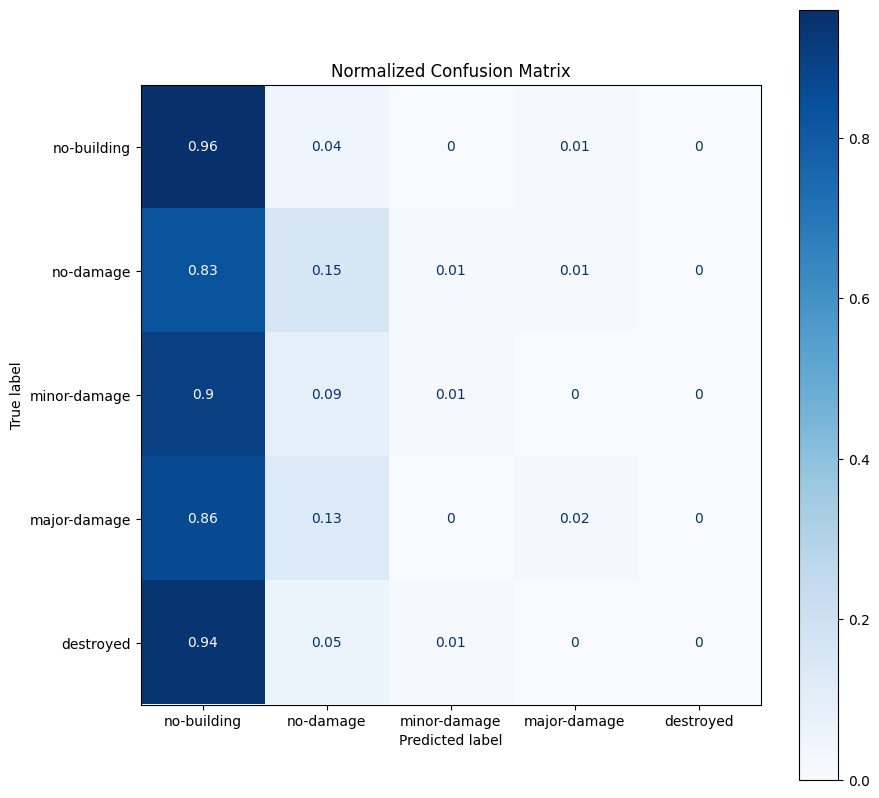

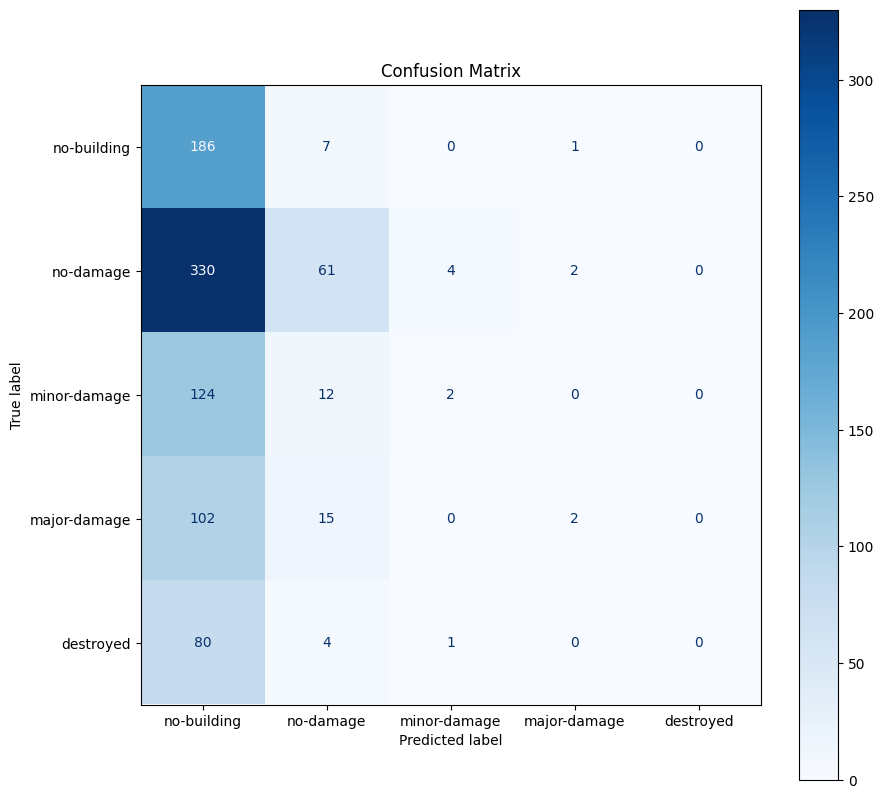

In [25]:
cm_norm = confusion_matrix(y_truth, y_pred, normalize="true")
cm = confusion_matrix(y_truth, y_pred)
l = [SCORE_TO_DAMAGE_LEVEL[i] for i in range(NUM_CLASSES)]

# Print Overall and Average Accuracy
overall_accuracy = np.sum(np.diag(cm))/np.sum(cm)
print(f'Overall Accuracy: {overall_accuracy:.3f}')
average_accuracy =  np.mean(np.diag(cm) / np.sum(cm, axis=1))
print(f'Average Accuracy: {average_accuracy:.3f}')

file_path = os.path.join(out_dir,"accuracy.csv")
with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([f"Overall_Accuracy={overall_accuracy:.3f}"])
    writer.writerow([f"Average_Accuracy={average_accuracy:.3f}"])

# Display Normalized Confusion Matrix
disp = ConfusionMatrixDisplay(np.around(cm_norm, decimals=2), display_labels=l)
_, ax = plt.subplots(figsize=(10,10))
ax.set_title("Normalized Confusion Matrix")
disp.plot(ax=ax, cmap="Blues")
plt.savefig(os.path.join(out_dir, 'cm_norm.svg'), format='svg')

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(np.around(cm, decimals=2), display_labels=l)
_, ax = plt.subplots(figsize=(10,10))
ax.set_title("Confusion Matrix")
disp.plot(ax=ax, cmap="Blues")
plt.savefig(os.path.join(out_dir, 'cm.svg'), format='svg')

## Save Confusion Mat

In [26]:
SAVE_CM = True
if SAVE_CM:
    if(SAVE_MODEL):
        CM_FILE = SAVE_MODEL_FILE
    elif(LOAD_MODEL):
        CM_FILE = LOAD_MODEL_FILE
    with open(os.path.join(out_dir,'saved_cm.json'), 'w') as json_file:
        json.dump(cm.tolist(), json_file)